In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from scripts.smdp_agent import SMDPQLearningAgent
from scripts.intraoption_agent import IntraOptionQLearningAgent
from scripts.options import Option
from scripts.policies import MoveTaxiPolicy, EpsilonGreedyPolicy
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results, compute_decay

## Hyperparameters

In [2]:
def episode_trigger(x):
    if x % 1000 == 0:
        return True
    return False

def process_hyperparameters(hyperparameters):
    hyperparameters.update({
        "eps_decay": compute_decay(
            hyperparameters["eps_start"],
            hyperparameters["eps_end"],
            hyperparameters["frac_episodes_to_decay"],
            hyperparameters["num_episodes"],
            hyperparameters["decay_type"]
        )
    })

    hyperparameters.pop("frac_episodes_to_decay", None)
    return hyperparameters
    

In [3]:
# Top 3 hyperparameter configurations
intraoption_hyperparameter_list = [

    process_hyperparameters(_) for _ in  [
    # Best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": 8,
        "LR": 1e-3,
        "eps_start": 1,
        "eps_end": 0.001,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.5
    }

]]

## Running Experiments

In [4]:
def get_termination(source):
    # ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
    location_map = {
        (0, 0): 0,
        (4, 0): 2,
        (0, 4): 1,
        (4, 3): 3
    }
    termination = [0 for i in range(500)]
    
    base = 100*source[0] + 20*source[1]
    idx = location_map[source]

    for i in range(4):
        for j in range(5):
            if j!=idx:
                termination[base + j*4 + i] = 1

    return termination
    
locations = {
    "R":(0, 0),
    "Y":(4, 0),
    "G":(0, 4),
    "B":(4, 3)
}

initiation_set = [True for i in range(500)]

options = [
    Option(0, initiation_set, MoveTaxiPolicy(locations["R"]), get_termination(locations["R"]), seed=0),
    Option(1, initiation_set, MoveTaxiPolicy(locations["Y"]), get_termination(locations["Y"]), seed=0),
    Option(2, initiation_set, MoveTaxiPolicy(locations["G"]), get_termination(locations["G"]), seed=0),
    Option(3, initiation_set, MoveTaxiPolicy(locations["B"]), get_termination(locations["B"]), seed=0),
]

In [5]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/taxi-intraoption-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

intraoption_agent = IntraOptionQLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    options=options,
    seed=0
)

trainer = Trainer()
intraoption_results = test_agent(env, intraoption_agent, trainer, intraoption_hyperparameter_list, num_experiments=1)
env.close()

# with open("backups/acrobot-plots/acrobot_ddqn_type1_results.pickle", 'wb') as handle:
#     pickle.dump(ddqn_type1_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment3/DA6400_RL_PA3/backups/taxi-intraoption-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


LR 0.001
eps_start 1
eps_end 0.001
decay_type exponential
eps_decay 0.9986194028465246


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.90it/s, Mean Score=-15.9]


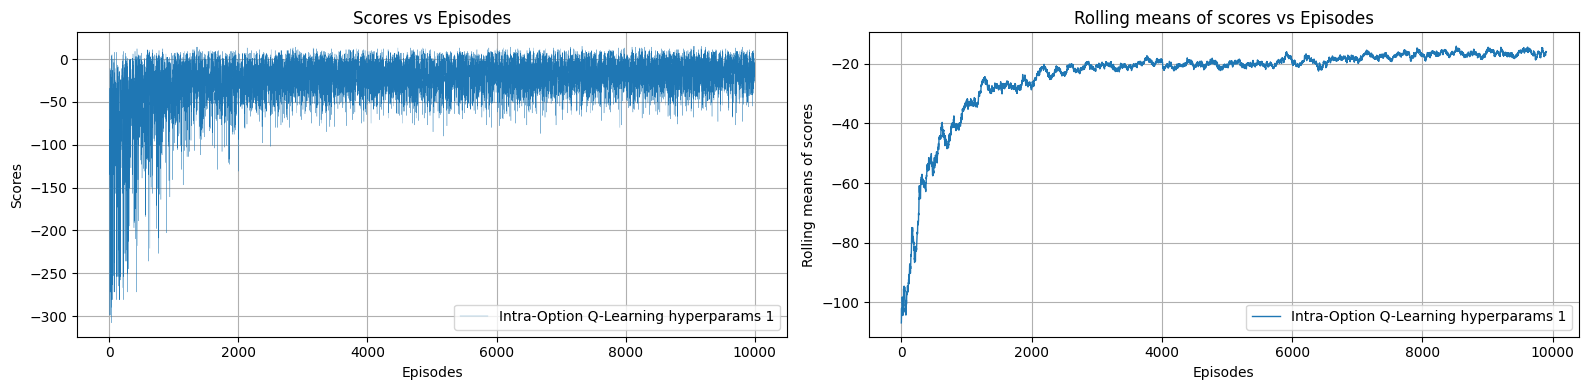

In [6]:
plot_test_results(intraoption_results, [0])